In [1]:
%%time
%cd /gpfs/data/johnsonslab/nlp-genomics/english_corpora
import pandas as pd
# pd.set_option('display.max_colwidth', None)
import gzip
import re
import tarfile
import os
import youtokentome as yttm
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from collections import defaultdict
import operator
import ftplib
from scipy.optimize import curve_fit
from functools import partial
#import pyperclip
import itertools
#import sentencepiece as spm
%matplotlib inline
from tqdm import tqdm
model_path = "brown_8192k.model"
bpe = yttm.BPE(model=model_path)




/gpfs/data/johnsonslab/nlp-genomics/english_corpora
CPU times: user 1.29 s, sys: 457 ms, total: 1.75 s
Wall time: 9.37 s


In [4]:
print(pd.__version__)

2.0.3


In [28]:
print(bpe.vocab_size())

139240


### Counting token frequencies

In [29]:
%%time
import operator
freqs = {}
threshold = 0
total_len = 0
total_count = 0
i = 0
with(open('brown_nowhitelines.txt', 'r')) as f:
    for line in f:
        i+=1
        tokens= bpe.encode(line.strip(), output_type =yttm.OutputType.SUBWORD )
        if i==1:print(tokens)
#         tokens = tokenize(line.strip(), length_threshold=threshold)
        total_len +=len(tokens)
        total_count +=1
        for token in tokens:
            if token not in freqs.keys():
                freqs[token] = 1
            else:
                freqs[token]+=1
sorted_freqs = sorted(freqs.items(), key=operator.itemgetter(1), reverse=True)
print(len(sorted_freqs))
print("Average tokenization length: ", total_len/total_count)



['▁The', '▁Fulton', '▁County', '▁Grand', '▁Jury', '▁said', '▁Friday', '▁an', '▁investigation', '▁of', "▁Atlanta's", '▁recent', '▁primary', '▁election', '▁produced', '▁"no', '▁evidence"', '▁that', '▁any', '▁irregularities', '▁took', '▁place.']
100236
Average tokenization length:  70.76697810626133
CPU times: user 2.53 s, sys: 10.4 ms, total: 2.54 s
Wall time: 3.23 s


4
[[0.         1.        ]
 [0.30103    1.        ]
 [0.47712125 1.        ]
 ...
 [5.00101506 1.        ]
 [5.00101939 1.        ]
 [5.00102373 1.        ]] [[4.79539333]
 [4.55505816]
 [4.43825747]
 ...
 [0.        ]
 [0.        ]
 [0.        ]]


Text(0, 0.5, 'Log10 Frequency')

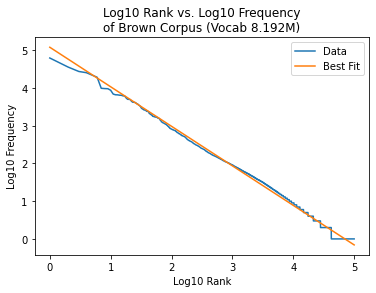

In [30]:
sorted_freq_values = []
sorted_freq_lengths = []
freq_threshold=0
print(len(sorted_freqs[0][0]))
for freq in sorted_freqs:
    sorted_freq_values.append(freq[1])
    if(freq[1]>freq_threshold):
        sorted_freq_lengths.append(len(freq[0]))
        
ranks = np.arange(1, len(sorted_freqs) + 1)
x = np.log10(ranks).reshape(len(ranks), 1)
X = np.append(x, np.ones((len(ranks), 1)), axis=1)
y = np.array(np.log10(sorted_freq_values)).reshape(len(sorted_freq_values), 1)
print(X, y)
theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
y_line = X.dot(theta)
plt.plot(np.log10(ranks), np.log10(sorted_freq_values))
plt.plot(x, y_line)
plt.title('Log10 Rank vs. Log10 Frequency\nof Brown Corpus (Vocab 8.192M)')
plt.legend(['Data', 'Best Fit'])
plt.xlabel('Log10 Rank')
plt.ylabel('Log10 Frequency')

In [31]:
total = 0 
for i in range(1, len(sorted_freq_values)):
    total+= sorted_freq_values[i-1]
    if total>=sum(sorted_freq_values)/2:
        break
print("number of types to reach 50%: ", i)
print(i/len(sorted_freq_values) * 100, "% of types make up half of all tokens")

number of types to reach 50%:  230
0.229458477991939 % of types make up half of all tokens


In [32]:
sfv_array = np.array(sorted_freq_values)
singles = sfv_array[sfv_array<=1]
print(len(singles), "types only appear once in all tokenizations")
print(len(singles)/len(sorted_freq_values) * 100, "% of all types only appear once")
print("Half of all types appear", sorted_freq_values[int(len(sorted_freq_values)/2)], "times or fewer")


58140 types only appear once in all tokenizations
58.00311265413624 % of all types only appear once
Half of all types appear 1 times or fewer


Text(0, 0.5, 'Frequency')

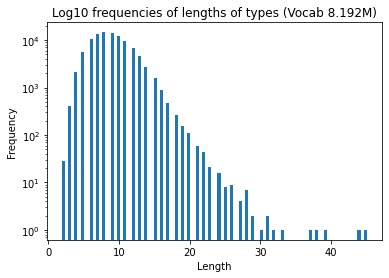

In [33]:
plt.hist((sorted_freq_lengths), bins=100, log=True)
plt.title("Log10 frequencies of lengths of types (Vocab 8.192M)")
plt.xlabel("Length")
plt.ylabel("Frequency")